In [1]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# torchvision
from torchvision import models
import torchvision.transforms.v2 as tfs_v2

# scikit-learn
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report, 
    roc_curve, 
    auc, 
    roc_auc_score
)

# e.t.c.
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from datetime import datetime

In [2]:
PROJECT_DIR_PATH = os.path.abspath(os.path.curdir)
DATASET_DIR_PATH = os.path.join(PROJECT_DIR_PATH, 'dataset')
NUM_CLASSES = 15

#### If using kaggle kernel

In [3]:
if ('kaggle/working' in PROJECT_DIR_PATH):
    input_dir = "/kaggle/input/x-ray-pytorch"
    output_dir = "/kaggle/working/dataset"
    
    os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(input_dir):
        raise FileNotFoundError(f'directory {input_dir} not exist')
    
    shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)
    print("Копирование завершено")

Копирование завершено


In [4]:
class XRayDataset(data.Dataset):
    def __init__(self, path: str, type_file: str, transform=None):
        self.path = path
        self.type_file = type_file
        self.transform = transform

        self.length = 0
        self.classes = torch.eye(15)

        not_split_data = self.get_unpack_img()
        files, targets, _length = self.split_data(not_split_data)

        self.df = pd.DataFrame({'path': files, 'target': targets})
        self.length = self.df.shape[0]

    def __getitem__(self, index: int):
        file_path, target = self.df.iloc[index]
        img = Image.open(file_path).convert('RGB')
        
        if (self.transform is not None):
            img = self.transform(img)
        
        return img, self.classes[target]

    def __len__(self):
        return self.length

    def get_unpack_img(self) -> list:
        type_file_path = os.path.join(self.path, self.type_file)

        if os.path.exists(type_file_path):
            shutil.rmtree(type_file_path)

        os.makedirs(type_file_path, exist_ok=True)

        parquet_files = [f for f in os.listdir(self.path) if f.startswith(
            self.type_file) and f.endswith('.parquet')]

        result = []

        for file_name in tqdm(parquet_files, desc=f"Unpacking {self.type_file}"):
            df = pd.read_parquet(os.path.join(self.path, file_name))

            for idx, row in df.iterrows():
                img_path = os.path.join(type_file_path, f"image_{idx}.png")

                if isinstance(row['image']['bytes'], bytes):
                    with open(img_path, 'wb') as f:
                        f.write(row['image']['bytes'])
                # else:
                #     img = Image.fromarray(row['image'])
                #     img.save(img_path)

                result.append((img_path, row['labels']))

        return result

    def split_data(self, not_split_data: list):
        files = []
        targets = []
        length = 0

        for path, labels in not_split_data:
            for target in labels.tolist():
                files.append(path)
                targets.append(int(target))
                length += 1

        return files, targets, length

    def cut_dataframe(self, target: str | int, count: int) -> None:
        rows_to_drop = self.df[self.df['target'] == target].index[:count]
        self.df = self.df.drop(rows_to_drop)
        self.length = self.df.shape[0]

In [5]:
class XRayDensenet121(nn.Module):
    def __init__(self, output_dim):
        super(XRayDensenet121, self).__init__()

        self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        # for param in self.model.features.parameters():
        #     param.requires_grad = False

        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(.25),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(.25),
            nn.Linear(512, 15)
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
class Exec:
    def __init__(
        self,
        model : torch.nn.Module,
        # dataloader : torch.utils.data.DataLoader,
        num_class : int,
        optimizer = None,
        loss_function = None,
        save_compare_accuracy : float = 0.1,  # if new model better prev model more than 10%
        save_each_epoch : int = 1) -> None:

        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        # self.dataloader = dataloader
        self.num_class = int(num_class)
        self.save_compare_accuracy = save_compare_accuracy
        self.save_each_epoch = int(save_each_epoch)
        self.accuracy_list = []
        self.loss_mean_list = []

    def fit(
        self, 
        epochs: int,
        device,
        project_dir_path : str,
        train_dataset : torch.utils.data.Dataset,
        valid_dataset : torch.utils.data.Dataset | None = None,
        **kwargs) -> None:
        
        num_gpus = 0
        best_accurasy = 0
        
        # kwargs vars
        train_bs = 16
        valid_bs = 20
        model_name = 'dendensenet121'
        
        self.accuracy_list = []
        self.loss_mean_list = []
        
        for key, value in kwargs.items():
            if key == 'train_bs': train_bs = value
            if key == 'valid_bs': valid_bs = value
            print(key, value)
        
        if torch.cuda.is_available():
            num_gpus = torch.cuda.device_count()
            torch.cuda.empty_cache()
            if num_gpus > 0:
                self.model = nn.DataParallel(self.model)
        
        modal_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        fit_path = os.path.join(project_dir_path, 'models', model_name, modal_start_time)
        os.makedirs(fit_path, exist_ok=True)
        
        for _e in range(epochs):
            self.model.train()
            
            loss_mean = 0  # среднее значение функции потерь (по эпохе)
            lm_count = 0  # текущее количество слагаемых
            
            train_data = data.DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
            train_tqdm = tqdm(train_data, leave=True)
            
            for x_train, y_train in train_tqdm:
                x_train = x_train.to(device)
                y_train = y_train.to(device)

                self.optimizer.zero_grad()

                y_pred = self.model(x_train)
                loss = self.loss_function(y_pred, y_train)

                loss.backward()
                self.optimizer.step()

                lm_count += 1
                loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
                train_tqdm.set_description(
                    f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")


            if not valid_dataset is None:
                valid_accuracy = 0
                self.model.eval()
                valid_data = data.DataLoader(valid_dataset, batch_size=valid_bs, shuffle=False)

                for x_valid, y_valid in tqdm(valid_data, leave=True):
                    with torch.no_grad():
                        x_valid = x_valid.to(device)
                        y_valid = y_valid.to(device)

                        logits = self.model(x_valid)

                        y_valid = torch.argmax(y_valid, dim=1)
                        y_pred = torch.argmax(logits, dim=1)

                        valid_accuracy += torch.sum(y_valid == y_pred).item()

                valid_accuracy /= len(valid_dataset)
                self.accuracy_list.append(valid_accuracy)
                self.loss_mean_list.append(loss_mean)

            model_state_dict = {
                # 'tfs': self.transform.state_dict(),
                'opt': self.optimizer.state_dict(),
                'model': self.model.module.state_dict() if num_gpus > 1 else self.model.state_dict(),
                'epochs': _e + 1,
                'accuracy_list': self.accuracy_list,
                'loss_mean_list': self.loss_mean_list,
            }
            
            if (valid_dataset is None) and (best_accurasy * (1 + self.save_compare_accuracy) >  valid_accuracy):
                shutil.rmtree(f'{fit_path}/best_accuracy')
                os.makedirs(f'{fit_path}/best_accuracy', exist_ok=True)
                torch.save(model_state_dict, f"{fit_path}/best_accuracy/epoch_{_e + 1}.tar")

            if (_e + 1) % self.save_each_epoch == 0 and self.save_each_epoch > 0:
                os.makedirs(f'{fit_path}/save_each_epoch', exist_ok=True)
                torch.save(model_state_dict, f"{fit_path}/save_each_epoch/epoch_{_e + 1}.tar")
        
        if torch.cuda.is_available(): 
            torch.cuda.empty_cache()
    
    def evaluate(self, dataloader : torch.utils.data.DataLoader, device) -> tuple:

        all_labels = []
        all_preds = []
        all_probs = []

        self.model.eval()
        
        with torch.no_grad():
            for x_test, y_test in tqdm(dataloader, desc="Evaluating"):
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                
                logist = self.model(x_test)
                probs = torch.softmax(logist, dim=1)
                _, y_pred = torch.max(probs, 1) 
                
                all_labels.append(torch.argmax(y_test, dim=1))
                all_preds.append(y_pred.cpu())
                all_probs.append(probs.cpu())
        
        return (
            torch.cat(all_labels).cpu(), 
            torch.cat(all_preds).cpu(), 
            torch.cat(all_probs).cpu()
        )
    

In [7]:
class Diagram:
    def __init__(self):
        pass

    def show_stats_fit_by_epochs(self, epochs: int, accuracy: list, loss_mean: list) -> None:
        ep = [i + 1 for i in range(epochs)]

        fig, ax1 = plt.subplots(figsize=(8, 4))

        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Q value', color='b')
        line1 = ax1.plot(ep, accuracy, color='b', label='Q value')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Loss', color='r')
        line2 = ax2.plot(ep, loss_mean, color='r', label='Loss')
        ax2.tick_params(axis='y', labelcolor='r')

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper center')

        plt.title('Q values and Loss over epochs')
        plt.grid(True)
        plt.show()
      
    def multiclass_roc(self, labels, probs, num_classes, title='ROC Curves'):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(
                (labels == i).numpy(), 
                probs[:, i].numpy()
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Micro-average
        y_true_bin = label_binarize(labels.numpy(), classes=list(range(num_classes)))
        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_true_bin.ravel(), 
            probs.numpy().ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Macro-average
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= num_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plotting
        plt.figure(figsize=(10, 8))
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
                color='deeppink', linestyle=':', linewidth=4)
        
        plt.plot(fpr["macro"], tpr["macro"],
                label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
                color='navy', linestyle=':', linewidth=4)
        
        colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                    label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        return roc_auc



In [8]:
transforms = tfs_v2.Compose([
    tfs_v2.ToTensor(),
    tfs_v2.ToDtype(dtype=torch.float32, scale=True)
])

d_train = XRayDataset(DATASET_DIR_PATH, 'train', transform=transforms)
d_valid = XRayDataset(DATASET_DIR_PATH, 'validation', transform=transforms)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Unpacking validation: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = XRayDensenet121(NUM_CLASSES)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-3)

ex = Exec(model, NUM_CLASSES, loss_function=loss_function, optimizer=optimizer)

In [10]:
# ex.fit(epochs=5, device=device, project_dir_path=PROJECT_DIR_PATH, train_dataset=d_train, valid_dataset=d_valid, train_bs = 10, valid_bs = 10)

In [12]:
dg = Diagram()
# dg.show_stats_fit_by_epochs(5, ex.accuracy_list, ex.loss_mean_list)

In [42]:
model_data = torch.load('/kaggle/working/models/dendensenet121/2025-05-10 04:30:55/save_each_epoch/epoch_5.tar', weights_only=True, map_location=device)

state_dict = {k.replace('module.', ''): v for k, v in model_data['model'].items()}
model.load_state_dict(state_dict)

ex.model = model.to(device)

In [43]:
d_test = XRayDataset(DATASET_DIR_PATH, 'test', transform=transforms)
test_dataset = data.DataLoader(d_test, batch_size=20, shuffle=False)

Unpacking test: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


In [44]:
labels, preds, probs = ex.evaluate(test_dataset, device)

Evaluating: 100%|██████████| 92/92 [02:57<00:00,  1.93s/it]


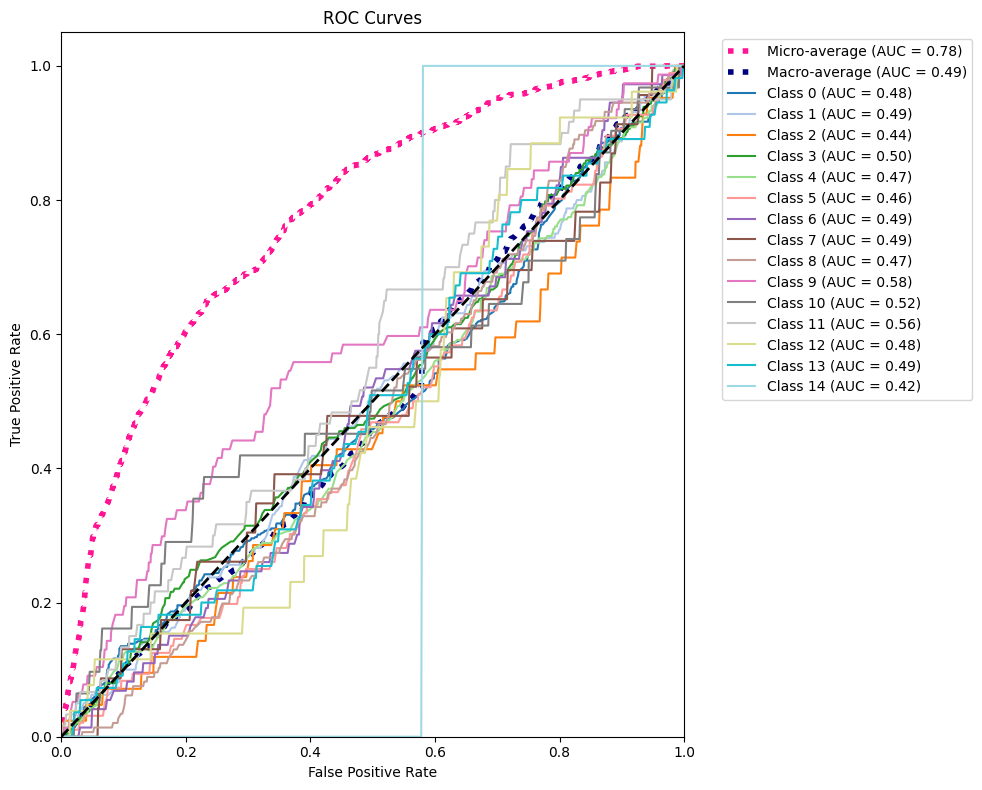

{0: 0.4819106750714884,
 1: 0.4934914568345324,
 2: 0.44388897776355785,
 3: 0.5010755970290266,
 4: 0.4722882306794133,
 5: 0.4637281081601232,
 6: 0.4894313702532881,
 7: 0.48527038419848245,
 8: 0.4744250158812894,
 9: 0.5834550943060366,
 10: 0.5157700109501498,
 11: 0.5585218702865762,
 12: 0.4809933407325194,
 13: 0.49145259703635336,
 14: 0.42063492063492064,
 'micro': 0.7760554361558556,
 'macro': 0.49042441259081226}

In [45]:
dg.multiclass_roc(labels=labels, probs=probs, num_classes=NUM_CLASSES)